In [1]:
# auto relode
%load_ext autoreload
%autoreload 2

# Ctrl model dataset

In [2]:
import pickle
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# dataset

class CtrlModelDataset:
    def __init__(self, path_to_pickle_files, num_past_time_steps, num_future_time_steps):
        self.path_to_pickle_files = path_to_pickle_files
        self.num_past_time_steps = num_past_time_steps
        self.num_future_time_steps = num_future_time_steps

        pickl_files = glob.glob(self.path_to_pickle_files + '/*')
        
        # read all pickle files
        self.optim_simulations = []
        for pickle_file in pickl_files:
            with open(pickle_file, 'rb') as f:
                optim_simulation = pickle.load(f)
                self.optim_simulations.extend(optim_simulation)

        self.simulation_time_steps = self.optim_simulations[0]['past_inputs'].shape[2] + self.optim_simulations[0]['future_optimized_inputs'].shape[2]

        self.num_data_pints_per_simulation = self.simulation_time_steps - num_past_time_steps - num_future_time_steps

    def __len__(self):
        return len(self.optim_simulations) * self.num_data_pints_per_simulation

    def __getitem__(self, idx):
        simulation = idx // self.num_data_pints_per_simulation
        time_step = idx % self.num_data_pints_per_simulation + self.num_past_time_steps

        # concat
        inputs = torch.cat([self.optim_simulations[simulation]['past_inputs'], self.optim_simulations[simulation]['future_optimized_inputs']], dim=2)
        outputs = torch.cat([self.optim_simulations[simulation]['past_outputs'], self.optim_simulations[simulation]['future_infered_outputs']], dim=2)
        internals = torch.cat([self.optim_simulations[simulation]['past_interals'], self.optim_simulations[simulation]['future_infered_interals']], dim=2)

        desired_outputs = self.optim_simulations[simulation]['desired_future_outputs']


        past_inputs = inputs[:, :, time_step - self.num_past_time_steps:time_step]
        past_outputs = outputs[:, :, time_step - self.num_past_time_steps:time_step]
        past_interals = internals[:, :, time_step - self.num_past_time_steps:time_step]

        future_desired_outputs = desired_outputs[:, :, time_step - self.num_past_time_steps:time_step + self.num_future_time_steps - self.num_past_time_steps]

        next_input = inputs[:, :, time_step]

        # Fix dimensions
        past_inputs = past_inputs.squeeze(0)
        past_outputs = past_outputs.squeeze(0)
        past_interals = past_interals.squeeze(0)
        future_desired_outputs = future_desired_outputs.squeeze(0)
        next_input = next_input.squeeze(0)

    
        return past_inputs, past_outputs, past_interals, future_desired_outputs, next_input

In [4]:
ctrl_model_dataset = CtrlModelDataset('./ctrl_datasets/2_added_genereted_future_outputs/', 30, 30)
len(ctrl_model_dataset)

182070

In [5]:
# dataloader
from torch.utils.data import DataLoader

ctrl_model_dataloader = DataLoader(ctrl_model_dataset, batch_size=2, shuffle=True)

In [122]:
# Get one item from dataset
past_inputs, past_outputs, past_interals, future_desired_outputs, next_input = next(iter(ctrl_model_dataloader))

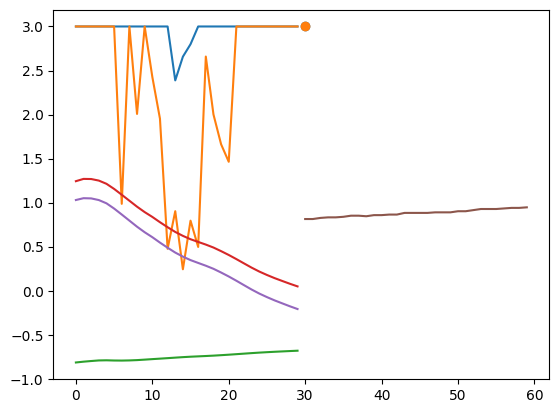

In [123]:
# Plot infered evolution
for i in range(past_inputs.shape[1]):
    ys = past_inputs[0, i, :].detach().numpy()
    xs = np.arange(len(ys))
    plt.plot(xs, ys)
for i in range(past_outputs.shape[1]):
    ys = past_outputs[0, i, :].detach().numpy()
    xs = np.arange(len(ys))
    plt.plot(xs, ys)
for i in range(past_interals.shape[1]):
    ys = past_interals[0, i, :].detach().numpy()
    xs = np.arange(len(ys))
    plt.plot(xs, ys)
for i in range(future_desired_outputs.shape[1]):
    ys = future_desired_outputs[0, i, :].detach().numpy()
    xs = np.arange(len(past_interals[0, 0, :].detach().numpy()), len(past_interals[0, 0, :].detach().numpy()) + len(ys))
    plt.plot(xs, ys)
# mark x the next input
for i in range(next_input.shape[1]):
    plt.scatter(len(past_interals[0, 0, :].detach().numpy()), next_input[0, i].detach().numpy())

In [8]:
future_desired_outputs[0, 0, :].detach().numpy().shape

(30,)

# Ctrl model

In [9]:
from ctrl_model import CtrlModel
import torch

In [10]:
ctrl_model = CtrlModel(
    num_past_time_steps=30,
    num_future_time_steps=30,
    num_input_vars=2,
    num_output_vars=1,
    num_internal_vars=2
)

In [11]:
import sys
sys.path.append('../sys_model/')

from system_model import SysModel

In [12]:
sys_model = SysModel(
    num_past_time_steps = 30,
    num_input_vars = 2,
    num_output_vars = 1,
    num_internal_vars = 2,
)

sys_model.load_state_dict(torch.load('../sys_model/sys_model_2023-03-03_15-33-21.pt'))

<All keys matched successfully>

In [13]:
# transfer lauer weights
ctrl_model.conv1.weight = torch.nn.Parameter(sys_model.conv1.weight)
ctrl_model.conv1.bias = torch.nn.Parameter(sys_model.conv1.bias)
ctrl_model.conv2.weight = torch.nn.Parameter(sys_model.conv2.weight)
ctrl_model.conv2.bias = torch.nn.Parameter(sys_model.conv2.bias)
ctrl_model.conv3.weight = torch.nn.Parameter(sys_model.conv3.weight)
ctrl_model.conv3.bias = torch.nn.Parameter(sys_model.conv3.bias)

ctrl_model.fc1.weight = torch.nn.Parameter(sys_model.fc1.weight)
ctrl_model.fc1.bias = torch.nn.Parameter(sys_model.fc1.bias)

# Freeze transfered layers
for param in ctrl_model.conv1.parameters():
    param.requires_grad = False
for param in ctrl_model.conv2.parameters():
    param.requires_grad = False
for param in ctrl_model.conv3.parameters():
    param.requires_grad = False
for param in ctrl_model.fc1.parameters():
    param.requires_grad = False
    

In [44]:
saved_w = ctrl_model.fc_new2.weight.clone().detach().cpu().numpy()

In [47]:
saved_w2 = ctrl_model.fc_new2.weight.clone().detach().cpu().numpy()

In [51]:
ctrl_model.conv1.weight.grad

In [52]:
# train using pytorch lightning

import pytorch_lightning as pl

trainer = pl.Trainer(
    gpus=1,
    max_epochs=10
)

trainer.fit(ctrl_model, ctrl_model_dataloader)

/home/nils/miniconda3/envs/i2dl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | conv1   | Conv1d | 100   
1 | conv2   | Conv1d | 620   
2 | conv3   | Conv1d | 5.3 K 
3 | fc1     | Linear | 9.2 K 
4 | conv_f1 | Conv1d | 12    
5 | conv_f2 | Conv1d | 30    
6 | fc_new2 | Linear | 9.1 K 
7 | fc_new3 | Linear | 620   
8 | fc_new4 | Linear | 42    
-----------------------------------
9.8 K     Trainable params
15.2 K    Non-trainable params
25.0 K    Total params
0.100     Total estimated model p

Training: 0it [00:00, ?it/s]

/home/nils/repos/w22-test-bench/controllers/nn_1/dev/ctrl_model/ctrl_model.py:198: UserWarning: Using a target size (torch.Size([2, 2])) that is different to the input size (torch.Size([2, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(next_predicted_input, next_input)
/home/nils/miniconda3/envs/i2dl/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [41]:
# check the average loss
trainer.test(ctrl_model, ctrl_model_dataloader)
# [{'test_loss': 5.459200859069824}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/nils/miniconda3/envs/i2dl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/nils/miniconda3/envs/i2dl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/nils/repos/w22-test-bench/controllers/nn_1/dev/ctrl_model/ctrl_model.py:205: UserWarning: Using a target size (torch.Size([2, 2])) that is different to the input size (torch.Size([2, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(next_predicted_input, next_input)


# test model

In [14]:
# load model from pt file
ctrl_model.load_state_dict(torch.load('./ctrl_model_2023-03-09_18-18-38.pt'))

<All keys matched successfully>

In [23]:
# dataloader
from torch.utils.data import DataLoader

ctrl_model_dataloader = DataLoader(ctrl_model_dataset, batch_size=2, shuffle=True)

In [28]:
ctrl_model.eval()


In [98]:

# Get one item from dataset
past_inputs, past_outputs, past_interals, future_desired_outputs, next_input = next(iter(ctrl_model_dataloader))

next_infered_input = ctrl_model(past_inputs, past_outputs, past_interals, future_desired_outputs)

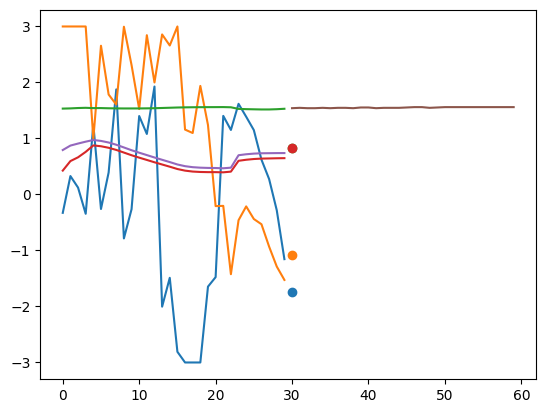

In [199]:
# Get one item from dataset
past_inputs, past_outputs, past_interals, future_desired_outputs, next_input = next(iter(ctrl_model_dataloader))

next_infered_input = ctrl_model(past_inputs, past_outputs, past_interals, future_desired_outputs)



# Plot infered evolution
for i in range(past_inputs.shape[1]):
    ys = past_inputs[0, i, :].detach().numpy()
    xs = np.arange(len(ys))
    plt.plot(xs, ys)
for i in range(past_outputs.shape[1]):
    ys = past_outputs[0, i, :].detach().numpy()
    xs = np.arange(len(ys))
    plt.plot(xs, ys)
for i in range(past_interals.shape[1]):
    ys = past_interals[0, i, :].detach().numpy()
    xs = np.arange(len(ys))
    plt.plot(xs, ys)
for i in range(future_desired_outputs.shape[1]):
    ys = future_desired_outputs[0, i, :].detach().numpy()
    xs = np.arange(len(past_interals[0, 0, :].detach().numpy()), len(past_interals[0, 0, :].detach().numpy()) + len(ys))
    plt.plot(xs, ys)
# mark x the next input
for i in range(next_input.shape[1]):
    plt.scatter(len(past_interals[0, 0, :].detach().numpy()), next_input[0, i].detach().numpy())
# mark x the infered next input
for i in range(next_infered_input.shape[1]):
    plt.scatter(len(past_interals[0, 0, :].detach().numpy()), next_infered_input[0, i].detach().numpy())

In [94]:
next_infered_input[0]

tensor([[2.2650],
        [2.2395]], grad_fn=<SelectBackward0>)